Optimal Planning with Dynamic Motion Primitives in Obstacle Scenarios
====

read successfully..
5.544444561000001


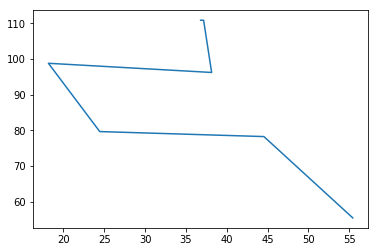

In [69]:
# libraries for loading the recorded trajectory and plotting

import matplotlib.pyplot as plt
from utils import get_trajectory

# the trajectory has been recorded in the ROS turtlesim by using the keyboard teleop interface and converted to a csv
# file from a rosbag file.

x, y = get_trajectory("../csv/data.csv")

# Scaling is done so that the node indices in grid search remain integeral for reso=1.0
x = [10 * i for i in x]
y = [10 * j for j in y]

plt.plot(x, y)
plt.show()

Path Imitation using DMP
----

In [70]:
from dmp_discrete import DMPs_discrete
import numpy as np

# specify the number of basis functions in n_bfs, time resolution as dt and total run time.
dmp = DMPs_discrete(n_dmps=2, n_bfs=100, dt=0.01, run_time=1.0)

# learn the weights for the basis functions
dmp.imitate_path(y_des=np.array([x, y]))
print("weights generated for the DMP")

weights generated for the DMP


Specify the start and goal positions for the rollout. In this example, we try to just use the same start and goal positions as in the demonstration.

In [71]:
dmp.y0[0] = x[0]
dmp.y0[1] = y[0]

dmp.goal[0] = x[-1]
dmp.goal[1] = y[-1]

y_track_nc, dy_track_nc, ddy_track_nc, s = dmp.rollout()

For plotting the rolled out trajectory, execute the cell below.

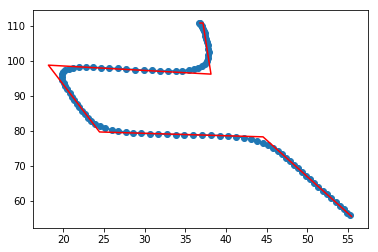

In [72]:
plt.plot(y_track_nc[:, 0], y_track_nc[:, 1])
plt.scatter(y_track_nc[:, 0], y_track_nc[:, 1])
plt.plot(x, y, color='r')

DMPs with Variable Start and Goal
---

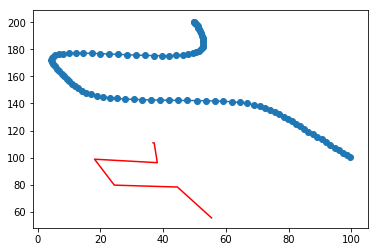

In [73]:
dmp.y0[0] = 100.0
dmp.y0[1] = 100.0

dmp.goal[0] = 50.0
dmp.goal[1] = 200.0

y_track2, dy_track2, ddy_track2, s2 = dmp.rollout()

plt.plot(y_track2[:, 0], y_track2[:, 1])
plt.scatter(y_track2[:, 0], y_track2[:, 1])
plt.plot(x, y, color='r')

Obstacle Worlds
---

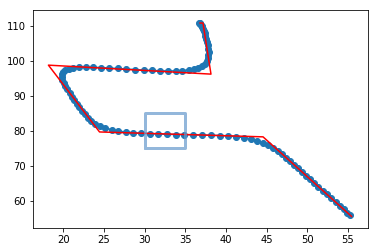

In [74]:
import math
from shapely.geometry.polygon import LinearRing, Polygon
from shapely.geometry import Point, mapping
from math import sqrt, ceil, floor

# specify the end points of the polygon.
coords = [(30.0, 75), (30, 85), (35, 85), (35, 75)]

obstacle = Polygon(coords)
ob_x, ob_y = obstacle.exterior.xy
plt.plot(y_track_nc[:, 0], y_track_nc[:, 1])
plt.scatter(y_track_nc[:, 0], y_track_nc[:, 1])
plt.plot(x, y, color='r')
plt.plot(ob_x, ob_y, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)


As you can see, since the demonstration was for an obstacle free scenario, the path rolled out by the DMP is not able to adapt to the obstacle that is present in the environment. Therefore, for making this adapt to the obstacle scenario, we try out various approaches: (1). Potential fields (2). Grid Search (3). Probabilistic Roadmaps (4). Time-Space Probabilistic Roadmap

Potential Field Methods
---

We first try out a potential field method. A point repulsive field is applied throughout the rolled out trajectory. The point repulsive field for a given point on the DMP, is the closest point on the obstacle to the DMP.

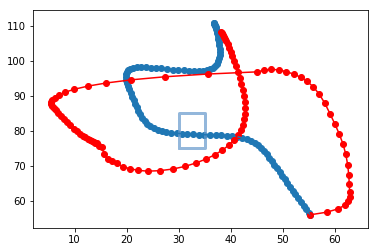

In [75]:
from utils import avoid_obstacles

# TODO: Alternative potential field expressions

dmp.y0[0] = x[0]
dmp.y0[1] = y[0]

dmp.goal[0] = x[-1]
dmp.goal[1] = y[-1]


y_track_pot, dy_track_pot, ddy_track_pot, s = dmp.rollout(obstacles=[obstacle], external_force=avoid_obstacles)


plt.plot(ob_x, ob_y, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

plt.plot(y_track_nc[:, 0], y_track_nc[:, 1])
plt.scatter(y_track_nc[:, 0], y_track_nc[:, 1])

plt.plot(y_track_pot[:, 0], y_track_pot[:, 1], color='r')
plt.scatter(y_track_pot[:, 0], y_track_pot[:, 1], color='r')

Grid Search Based Methods
---

Above we can see that the obstacle field is not able to make the path feasible. The approach requires tuning hyperparamters such as the strength of the field. For many scenarios the approach might work but it provides no gurantee of feasibility and optimality. However, it is computationally cheaper than some of the other approaches that would be discussed later.

Now, we try out a Grid based Method, which gives a gurantee of finding a feasible solution if one exists given a small enough grid resolution. The edge weight is defined as the 2D euclidean distance of the grid point from the nearest point on the DMP, which serves as a guiding path. 

Once a graph is constructed from the grid points, a graph search algorithm is used to return the lowest cost path.

In [94]:
%matplotlib inline
import matplotlib.pyplot as plt

from grid_search import Node, calc_final_path, verify_node, calc_index
from math import modf, sqrt, ceil, floor

# TODO: Animation plot in the single graph

show_animation = False
def calc_obstacle_map(obstacles, reso):

    minx = 0
    miny = 0
    maxx = 1000
    maxy = 1000

    xwidth = round(maxx - minx)
    ywidth = round(maxy - miny)

    # obstacle map generation
    obmap = [[False for i in range(xwidth)] for i in range(ywidth)]
    for ix in range(xwidth):
        x = ix + minx
        for iy in range(ywidth):
            y = iy + miny
            point = Point((reso * x, reso * y))
            for obstacle in obstacles:
                if obstacle.contains(point):
                    obmap[ix][iy] = True
                    break

    return obmap, minx, miny, maxx, maxy, xwidth, ywidth

                    
def dijkstra_planning(sx, sy, gx, gy, obstacles, reso, dmp=None,
                      dmp_vel=None, dt=0.01, deviation_penalty=True):
    """
    :param sx: start x coordinate
    :param sy: start y coordinate
    :param gx: goal x coordinate
    :param gy: goal y coordinate
    :param obstacles: list of shapely polygons
    :param reso: resolution of smaller grids
    :param cost_type: type of cost defining edge weights
    :param dmp: path given by a dmp
    :param dmp_vel: dmp_velocities
    :param dt: time resolution of the dmp
    :return: time parameterised path

    """
    print("start is: ", (sx, sy))
    print("goal is: ", (gx, gy))
    # scale the dmp and its velocities according to the resolution of the grid.
    print("shape of dmp is: ", dmp.shape)
    print("shape of dmp velocity is: ", dmp_vel.shape)
    for i in range(0, len(dmp)):
        for j in range(0, len(dmp[i])):
            dmp[i][j] = dmp[i][j] / reso
            dmp_vel[i][j] = dmp[i][j] / reso

    nstart = Node(round(sx / reso), round(sy / reso), 0.0, -1)

    ngoal = Node(round(gx / reso), round(gy / reso), 0.0, -1, len(dmp))

    ngoal = Node(round(gx / reso), round(gy / reso), 0.0, -1)

    obmap, minx, miny, maxx, maxy, xw, yw = calc_obstacle_map(obstacles, reso)

    motion = [[1, 0, 1],
              [0, 1, 1],
              [-1, 0, 1],
              [0, -1, 1],
              [-1, -1, math.sqrt(2)],
              [-1, 1, math.sqrt(2)],
              [1, -1, math.sqrt(2)],
              [1, 1, math.sqrt(2)]]

    openset, closedset = dict(), dict()
    openset[calc_index(nstart, xw, minx, miny)] = nstart

    while 1:
        c_id = min(openset, key=lambda o: openset[o].cost)
        current = openset[c_id]
        # show graph
        plt.plot(current.x * reso, current.y * reso, "xc")
        if show_animation:            
            if len(closedset.keys()) % 10 == 0:
                plt.pause(0.1)

        if current.x == ngoal.x and current.y == ngoal.y:
            print("[INFO]: searched reached the goal")
            ngoal.pind = current.pind
            ngoal.cost = current.cost
            break

        # Remove the item from the open set
        del openset[c_id]
        # Add it to the closed set
        closedset[c_id] = current

        # expand search grid based on motion model
        for i, _ in enumerate(motion):
            dmp_cost = calculate_dmp_cost(current.x, current.y,
                                          motion[i][0], motion[i][1],
                                          dmp, dmp_vel, obstacles, reso, dt,
                                          dev_penalty=deviation_penalty)
            node = Node(current.x + motion[i][0], current.y + motion[i][1],
                            current.cost + dmp_cost,
                            c_id)

            n_id = calc_index(node, xw, minx, miny)

            if not verify_node(node, obmap, minx, miny, maxx, maxy):
                continue

            if n_id in closedset:
                continue
                
            # Otherwise if it is already in the open set
            if n_id in openset:
                # print("nid exists in openset")
                if openset[n_id].cost > node.cost:
                    openset[n_id].cost = node.cost
                    openset[n_id].pind = c_id

            else:
                openset[n_id] = node
    
    # call to final_path to give out the trail for the lowest cost path.
    rx, ry = calc_final_path(ngoal, closedset, reso)

    return rx, ry


def calculate_dmp_cost(x, y, motion_x, motion_y, dmp, dmp_vel, obstacles=None, reso=1.0, dt=0.01,
                      dev_penalty=True):
    """
    :param x: x coordinate of the point which we are moving to
    :param y: y coordinate of the point which we are moving to
    :param motion_x: distance to be moved along x
    :param motion_y: distance to be moved along y
    :param dmp: reference dmp
    :param dmp_vel: reference dmp velocities
    :param obstacles: list of shapely polygons
    :param reso: resolution of the 2D grid
    :return: cost of the given node

    """

    d = []

    for pt in dmp:
        distance = sqrt((x - pt[0]) ** 2 + (y - pt[1]) ** 2)
        d.append(distance)

    d = np.array(d)

    # closest point on the motion primitive.
    time_index = np.argmin(d)

    # time taken to traverse the required distance, if we were to travel at the velocity at the nearest DMP point.
    delta_t_index = floor((sqrt(motion_x ** 2 + motion_y ** 2)/sqrt(dmp_vel[time_index][0] ** 2 +
                                                              dmp_vel[time_index][1] ** 2))/dt) - 1
    
    if floor(time_index + delta_t_index) < len(dmp):
        
        # get the coordinates on the DMP for t + delta_t 
        dmp_0 = dmp[floor(time_index + delta_t_index)]

        if ceil(time_index + delta_t_index) < len(dmp):
            dmp_1 = dmp[ceil(time_index + delta_t_index)]
            dmp_next = dmp_0 + (dmp_1 - dmp_0) * modf(delta_t_index)[0]

        else:
            dmp_next = dmp_0

    dmp_x = dmp_next[0]
    dmp_y = dmp_next[1]

    obstacle_cost = 0
    if obstacles is not None:
        for obstacle in obstacles:
            pol_ext = LinearRing(obstacle.exterior.coords)
            d = pol_ext.project(Point(reso * (x + motion_x), reso * (y + motion_y)))
            p = pol_ext.interpolate(d)
            obst_potential_pt = list(p.coords)[0]
            dist = sqrt((y + motion_y - round(obst_potential_pt[1]/reso)) ** 2 +
                        (x + motion_x - round(obst_potential_pt[0]/reso)) ** 2)
            obstacle_cost += 1/((dist + 0.0000001) ** 2)

    # print("obstacle cost is: ", obstacle_cost)
    
    cost = sqrt((y + motion_y - dmp_y) ** 2 + (x + motion_x - dmp_x) ** 2) + obstacle_cost 
    
    if dev_penalty:
        cost -= sqrt((y - dmp[time_index][1]) ** 2 + (x - dmp[time_index][0]) ** 2)

    return cost

start is:  (55, 55)
goal is:  (36, 110)
shape of dmp is:  (100, 2)
shape of dmp velocity is:  (100, 2)
[INFO]: searched reached the goal
calculate final path called
final path calculated..


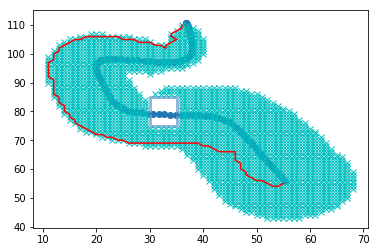

In [95]:
grid_size = 1.0

plt.plot(ob_x, ob_y, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

plt.plot(y_track_nc[:, 0], y_track_nc[:, 1])
plt.scatter(y_track_nc[:, 0], y_track_nc[:, 1])

rx, ry = dijkstra_planning(floor(x[0]), floor(y[0]), floor(x[-1]), floor(y[-1]), [obstacle], grid_size,
                          dmp=y_track_nc, dmp_vel=dy_track_nc, dt=dmp.dt)

plt.plot(rx, ry, "-r")

Without deviation penalty for the same goal and environment

In [ ]:
plt.plot(ob_x, ob_y, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

plt.plot(y_track_nc[:, 0], y_track_nc[:, 1])
plt.scatter(y_track_nc[:, 0], y_track_nc[:, 1])

rx, ry = dijkstra_planning(floor(x[0]), floor(y[0]), floor(x[-1]), floor(y[-1]), [obstacle], grid_size,
                          dmp=y_track_nc, dmp_vel=dy_track_nc, dt=dmp.dt, deviation_penalty=False)

plt.plot(rx, ry, "-r")

start is:  (55, 55)
goal is:  (36, 110)
shape of dmp is:  (100, 2)
shape of dmp velocity is:  (100, 2)


From the above two plots, we observe that subtracting the previous deviation is not helpful as it encourages deviation from the guiding path. However, this might help to search for alternate paths when the obstacle density is higher.

start is:  (55, 55)
goal is:  (36, 110)
shape of dmp is:  (100, 2)
shape of dmp velocity is:  (100, 2)
[INFO]: searched reached the goal
calculate final path called
final path calculated..


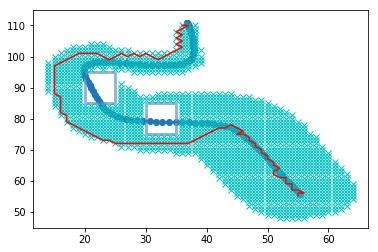

In [79]:
grid_size = 1.0

coords2 = [(20.0, 85), (20.0, 95), (25.0, 95), (25, 85)]

obstacle2 = Polygon(coords2)
ob_x2, ob_y2 = obstacle2.exterior.xy

plt.plot(ob_x, ob_y, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
plt.plot(ob_x2, ob_y2, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

plt.plot(y_track_nc[:, 0], y_track_nc[:, 1])
plt.scatter(y_track_nc[:, 0], y_track_nc[:, 1])

rx, ry = dijkstra_planning(floor(x[0]), floor(y[0]), floor(x[-1]), floor(y[-1]), [obstacle, obstacle2], grid_size,
                          dmp=y_track_nc, dmp_vel=dy_track_nc, dt=dmp.dt)

plt.plot(rx, ry, "-r")

start is:  (55, 55)
goal is:  (36, 110)
shape of dmp is:  (100, 2)
shape of dmp velocity is:  (100, 2)
[INFO]: searched reached the goal
calculate final path called
final path calculated..


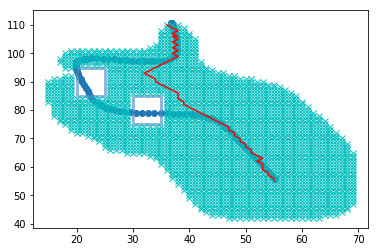

In [80]:
plt.plot(ob_x, ob_y, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
plt.plot(ob_x2, ob_y2, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

plt.plot(y_track_nc[:, 0], y_track_nc[:, 1])
plt.scatter(y_track_nc[:, 0], y_track_nc[:, 1])

rx, ry = dijkstra_planning(floor(x[0]), floor(y[0]), floor(x[-1]), floor(y[-1]), [obstacle, obstacle2], grid_size,
                          dmp=y_track_nc, dmp_vel=dy_track_nc, dt=dmp.dt, deviation_penalty=False)

plt.plot(rx, ry, "-r")

In this case, we can observe how the penalty terms plays it part as we get a more realistic curve with first plot. The above methods can be further speeded up by doing a forward-reverse search. 

Time-Space Grid Search 
---

Since, the cost is only dependent on the spatial distance from the guiding path, the search tends to jump forward in time to catch the future DMP points without consideration to time as seen in Fig 2.

To solve this we first align the 3D grid point(space-time) to the nearest space-time version of the DMP, and introduce the cost which is the spatial distance between the points.


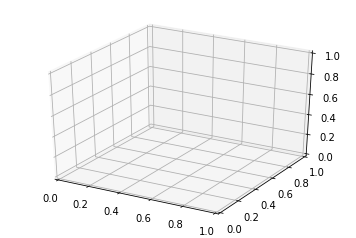

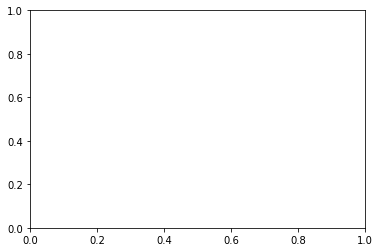

In [81]:
from grid_search_time import calc_final_path, verify_node, calc_obstacle_map

# TODO: Variants of the DMP cost.

show_animation = False
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

fig2 = plt.figure()
plt2d = fig2.add_subplot(111)

# changing the node definition to accomdate time coordinate
class Node(object):

    def __init__(self, x, y, t, cost, pind, dmp_closest_pt_index=None):
        self.x = x
        self.y = y
        self.t = t
        self.cost = cost
        self.pind = pind
        self.dmp_closest_pt_index = dmp_closest_pt_index

    def __str__(self):
        return str(self.x) + "," + str(self.y) + "," + str(self.t) + "," + str(self.cost) + "," + str(self.pind)


def dijkstra_planning(sx, sy, gx, gy, obstacles, reso, reso_time=0.1, dmp=None,
                      dmp_vel=None):
    """
    :param sx: start x coordinate
    :param sy: start y coordinate
    :param gx: goal x coordinate
    :param gy: goal y coordinate
    :param obstacles: list of shapely polygons
    :param reso: resolution for space
    :param reso_time: resolution for time
    :param cost_type: type of cost defining edge weights
    :param dmp: path given by a dmp
    :param dmp_vel: dmp_velocities
    :param dt: time resolution of the DMP
    :return: time parameterised path

    """
    
    # scale the dmp and its velocities according to the resolution of the grid.

    print("shape of dmp is: ", dmp.shape)
    print("shape of dmp velocity is: ", dmp_vel.shape)
    for i in range(0, len(dmp)):
        for j in range(0, len(dmp[i])):
            if j == 0 or j == 1:
                dmp[i][j] = dmp[i][j] / reso
                dmp_vel[i][j] = reso_time * dmp[i][j] / reso
            elif j == 2:
                dmp[i][j] = dmp[i][j] / reso_time
                dmp_vel[i][j] = dmp[i][j] / reso_time

    # print("dmp after scaling is: ", dmp)
    nstart = Node(round(sx / reso), round(sy / reso), 0.0, 0.0, -1)

    ngoal = Node(round(gx / reso), round(gy / reso), 0.0, 0.0, -1)

    obmap, minx, miny, maxx, maxy, xw, yw = calc_obstacle_map(obstacles, reso)

    # not all neighbors used, to keep the complexity of the problem under control
    motion = motion = [[1, 0, 1, math.sqrt(2)],
              [-1, 0, 1, math.sqrt(2)],
              [0, 1, 1, math.sqrt(2)],
              [0, -1, 1, math.sqrt(2)],
              [0, 0, 1, 1]]
    
    print("motion is: ", motion)
    openset, closedset = dict(), dict()
    openset[calc_index(nstart, xw, minx, miny)] = nstart

    while 1:

        c_id = min(openset, key=lambda o: openset[o].cost)
        current = openset[c_id]
        # print("min dmp index of current active search node is: ", current.dmp_closest_pt_index)
        # print("t coordinate of min dmp cost index is: ", dmp[current.dmp_closest_pt_index])
        # print("coordinate of the node are: ", current.x, current.y, current.t)
        # show graph
        if show_animation:
            # print("doing search for a new point")
            ax.scatter(current.x * reso, current.y * reso, current.t * reso_time)
            plt2d.scatter(current.x * reso, current.y * reso)
            if len(closedset.keys()) % 10 == 0:
                plt.pause(0.0000000000001)

        if current.x == ngoal.x and current.y == ngoal.y:
            print("[INFO]: searched reached the goal")
            ngoal.pind = current.pind
            ngoal.cost = current.cost
            ngoal.t = current.t
            break

        # Remove the item from the open set
        del openset[c_id]
        # Add it to the closed set
        closedset[c_id] = current

        # expand search grid based on motion model
        for i, _ in enumerate(motion):
            dmp_cost, min_index = calculate_dmp_cost(current.x, current.y, current.t,
                                              motion[i][0], motion[i][1], motion[i][2],
                                              dmp, dmp_vel, obstacles, reso=reso)

            node = Node(current.x + motion[i][0], current.y + motion[i][1],
                            current.t + motion[i][2], current.cost + dmp_cost,
                            c_id, min_index)
                # print("node is: ", node.t)
            n_id = calc_index(node, xw, minx, miny)
            if not verify_node(node, obmap, minx, miny, maxx, maxy):
                continue

            if n_id in closedset:
                continue
            # Otherwise if it is already in the open set
            if n_id in openset:
                if openset[n_id].cost > node.cost:
                    openset[n_id].cost = node.cost
                    openset[n_id].pind = c_id
            else:
                openset[n_id] = node

    rx, ry, rz = calc_final_path(ngoal, closedset, reso, reso_time)

    return rx, ry, rz


def calc_index(node, xwidth, xmin, ymin):
    # return (node.y - ymin) * xwidth + (node.x - xmin) + node.t
    return node.x, node.y, node.t


def calculate_dmp_cost(x, y, t, motion_x, motion_y, delta_t, dmp, dmp_vel, obstacles=None, reso=1.0):
    """
    :param x: x coordinate of the point which we are moving to
    :param y: y coordinate of the point which we are moving to
    :param t: t coordinate of the point which we are moving to
    :param motion_x: distance to be moved along x
    :param motion_y: distance to be moved along y
    :param delta_t: movement along time axis
    :param dmp: reference dmp
    :param dmp_vel: reference dmp velocities
    :param obstacles: list of shapely polygons
    :param reso: grid resolution
    :return: cost of the given node

    """

    d = []

    for pt in dmp:
        # print("cost due to time is:  ", (t - pt[2]) ** 2)
        # print("cost due to x is:  ", (x - pt[0]) ** 2)
        distance = sqrt((x + motion_x - pt[0]) ** 2 + (y + motion_y - pt[1]) ** 2 + (t + delta_t - pt[2]) ** 2)
        d.append(distance)

    d = np.array(d)

    min_index = np.argmin(d)
    # print("min index is: ", min_index)

    vx = motion_x/ delta_t
    vy = motion_y/ delta_t

    d_vel = []

    for pt in dmp:
        # print("cost due to time is:  ", (t - pt[2]) ** 2)
        # print("cost due to x is:  ", (x - pt[0]) ** 2)
        distance = sqrt((x - pt[0]) ** 2 + (y - pt[1]) ** 2 + (t - pt[2]) ** 2)
        d_vel.append(distance)

    d_vel = np.array(d_vel)

    min_index_vel = np.argmin(d_vel)

    cost = sqrt((x + motion_x - dmp[min_index][0]) ** 2 + (y + motion_y - dmp[min_index][1]) ** 2 +
                (vx - dmp_vel[min_index_vel][0]) ** 2 + (vy - dmp_vel[min_index_vel][1]) ** 2)

    obstacle_cost = 0
    if obstacles is not None:
        for obstacle in obstacles:
            pol_ext = LinearRing(obstacle.exterior.coords)
            d = pol_ext.project(Point(reso * (x + motion_x), reso * (y + motion_y)))
            p = pol_ext.interpolate(d)
            obst_potential_pt = list(p.coords)[0]
            dist = sqrt((y + motion_y - obst_potential_pt[1]/reso) ** 2 +
                        (x + motion_x - obst_potential_pt[0]/reso) ** 2)
            obstacle_cost += 100/((dist + 0.0000001) ** 2)

    # print("obstacle cost is: ", obstacle_cost)

    cost += obstacle_cost

    # print("total cost is: ", cost)

    return cost, min_index

In [82]:
y_track_nc_time = []
print("total time is: ", len(y_track_nc) * dmp.dt)
for i in range(0, len(y_track_nc)):
    y_track_nc_time.append((i + 1) * dmp.dt)

print("end time in the time array is: ", y_track_nc_time[-1])
y_track_nc_time = np.array([y_track_nc_time])
y_track_nc_x = np.array(y_track_nc[:, 0])
y_track_nc_y = np.array(y_track_nc[:, 1])

# plot time-space DMP.
ax.scatter(y_track_nc_x, y_track_nc_y, y_track_nc_time)
ax.plot_wireframe(y_track_nc_x, y_track_nc_y, np.zeros((1, len(y_track_nc))))


# plot obstacles
plt2d.plot(ob_x, ob_y, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

# plot spacial DMP
plt2d.plot(y_track_nc[:, 0], y_track_nc[:, 1])
plt2d.scatter(y_track_nc[:, 0], y_track_nc[:, 1])

# plot obstacle on the 3D plot
ax.plot_wireframe(np.array(ob_x), np.array(ob_y), np.zeros((1, len(ob_x))))

dmp_time_para = []
dmp_dy_time_para = []
for i in range(0, len(y_track_nc)):
    temp = list(y_track_nc[i])
    temp_vel = list(dy_track_nc[i])
    temp.append((i + 1) * dmp.dt)
    temp_vel.append((i + 1) * dmp.dt)
    dmp_dy_time_para.append(temp_vel)
    dmp_time_para.append(temp)

dmp_time_para = np.array(dmp_time_para)
dmp_dy_time_para = np.array(dmp_dy_time_para)

total time is:  1.0
end time in the time array is:  1.0


In [ ]:
rx, ry, rt = dijkstra_planning(floor(x[0]), floor(y[0]), floor(x[-1]), floor(y[-1]), [obstacle], grid_size,
                                   dmp=dmp_time_para, dmp_vel=dmp_dy_time_para)

rx = np.array(rx)
ry = np.array(ry)
rt = np.array([rt])
print("shape of rx is: ", rx.shape)

print("rt is: ", rt)
ax.plot_wireframe(rx, ry, rt)
plt2d.plot(rx, ry)

Probabilistic Roadmap Methods
---

The grid search based methods provide promising results however, they are really expensive which makes them unfit for any practical application, where the DOFs are really high.

Therefore, sampling based methods have been used for planning.

In [92]:
from prm import Node, KDTree, sample_normal
from shapely.geometry.polygon import LinearRing, Polygon, LineString
from math import log, pow
# uniform sampler
from prm import sample_points

N_SAMPLE = 1000  # number of sample_points

# some redundant variables, useful if we want to restrict number of neigbors of all edges and 
# use animation for plotting.

N_KNN = 100             # number of edge from one sampled point
MAX_EDGE_LEN = 10000.0  # [m] Maximum edge length
show_animation = False


show_animation = False

class Node:
    """
    Node class for dijkstra search
    """

    def __init__(self, x, y, cost, pind=None):
        self.x = x
        self.y = y
        # self.t = t
        self.cost = cost
        self.pind = pind

    def __str__(self):
        return str(self.x) + "," + str(self.y) + "," + str(self.cost) + "," + str(self.pind)

    
def PRM_planning(sx, sy, gx, gy, obstacles, dmp=None, num_points=N_SAMPLE, dmp_vel=None,
                sampling_distribution="uniform"):

    
    if sampling_distribution == "uniform":
        sample_x, sample_y = sample_points(sx, sy, gx, gy, obstacles, dmp=dmp)
        
    # some corrections in the implementation of the sample_normal are yet to be done.
    elif sampling_distribution == "dmp_normal":
        sample_x, sample_y = sample_normal(sx, sy, gx, gy, obstacles, dmp=dmp)
        
    if show_animation:
        plt.plot(sample_x, sample_y, ".b")
        plt.pause(0.01)

    road_map = generate_roadmap(sample_x, sample_y, obstacles)

    rx, ry = dijkstra_planning(sx, sy, gx, gy, road_map, sample_x, sample_y, obstacles, dmp, dmp_vel)

    return rx, ry


def generate_roadmap(sample_x, sample_y, obstacles, dynamic_radius=False):

    print("min x index is: ", np.argmin(np.array(sample_x)))
    road_map = []
    nsample = len(sample_x)
    print("no of sample_x pts are: ", len(sample_x))
    print("shape of sample_x is: ", np.array(sample_x).shape)
    print("shape of sample_y is: ", np.array(sample_y).shape)
    print("shape of kdtree parameter: ", np.vstack((sample_x, sample_y)).T.shape)
    skdtree = KDTree(np.vstack((sample_x, sample_y)).T)

    for (i, ix, iy) in zip(range(nsample), sample_x, sample_y):
        
        gamma = 10.0
        if dynamic_radius:
            if i == 0 or i == 1:
                search_radius = 100.0
            else:
                # since it is a 2D configuration space we will use power 0.5 for the asymptotically optimal case.
                search_radius = gamma * pow((log(i)/ i), 0.5)
        
        else:
            search_radius = 40
            
        index = skdtree.search_in_distance(np.array([ix, iy]), search_radius)

        # old code to if we want to ensure each node is connected to at least a certain number of neighbors
        # which is done dynamically doubling the search radius.
        
#         dist = 10
#         dist_max = 40
#         while len(index) < 10 and dist <= dist_max:
#             # print("length of index is less than ten and is: ", len(index))
#             dist *= 2
#             index = skdtree.search_in_distance(np.array([ix, iy]), dist)
#             # print("length of index for a bigger ball is: ", len(index))

        # print("index is: ", index)
        # inds = index[0]
        # print("length of index is: ", len(index))
        inds = index
        edge_id = []

        for ii in range(1, len(inds)):
            nx = sample_x[inds[ii]]
            ny = sample_y[inds[ii]]

            l = LineString([[ix, iy], [nx, ny]])
            for obstacle in obstacles:
                if not l.intersects(obstacle):
                    edge_id.append(inds[ii])
                    # plt.plot([ix, nx], [iy, ny], 'bo')

              # to be used if you want to cap the number of outgoing edges from a node in the roadmap.
#             if len(edge_id) >= N_KNN:
#                 break

        road_map.append(edge_id)

    return road_map


def dijkstra_planning(sx, sy, gx, gy, road_map, sample_x, sample_y, obstacles, dmp=None,
                      dmp_vel=None, deviation_penalty=False):
    """
    gx: goal x position [m]
    gx: goal x position [m]
    ox: x position list of Obstacles [m]
    oy: y position list of Obstacles [m]
    reso: grid resolution [m]
    rr: robot radius[m]
    """
    
    # useful when using the space-time implementation. vmax and vmin decide what are the corresponding 
    # feasible edges in space-time for an edge in the 2D roadmap
    
#     vel = []
#     for v in dmp_vel:
#         vel.append(math.sqrt(v[0] ** 2 + v[1] ** 2))

#     vel = np.array(vel)

#     v_max = max(vel)
#     v_min = min(vel)

#     print("v_max is: ", v_max)
#     print("v_min is: ", v_min)

    print("length of roadmap is: ", len(road_map))
    print("length of sample_x is: ", len(sample_x))

    nstart = Node(sx, sy, 0.0, -1)
    ngoal = Node(gx, gy, 0.0, -1)

    openset, closedset = dict(), dict()
    openset[len(road_map) - 2] = nstart

    while True:
        if not openset:
            print("Cannot find path")
            break

        c_id = min(openset, key=lambda o: openset[o].cost)
        current = openset[c_id]

        # show graph
        if show_animation and len(closedset.keys()) % 2 == 0:
            plt.plot(current.x, current.y, "xg")
            ax.scatter(current.x, current.y, current.t)
            plt.pause(0.001)

        if c_id == (len(road_map) - 1):
            print("goal is found!")
            ngoal.pind = current.pind
            ngoal.cost = current.cost
            # ngoal.t = current.t
            break

        # Remove the item from the open set
        del openset[c_id]
        # Add it to the closed set
        closedset[c_id] = current

        # expand search grid based on motion model
        # cheaper methods need to be used to find out the closest points instead of iterating over each
        # outgoing edge from the node.
        
        for i in range(len(road_map[c_id])):
            # get the 2D coordinates of the edge end point 
            n_id = road_map[c_id][i]
            dx = sample_x[n_id] - current.x
            dy = sample_y[n_id] - current.y
            
            dmp_cost = calculate_dmp_cost(current.x, current.y,  dx, dy,
                                          dmp, dmp_vel, obstacles, deviation_penalty)
            node = Node(sample_x[n_id], sample_y[n_id],
                        current.cost + dmp_cost, c_id)

            if n_id in closedset:
                continue
            # Otherwise if it is already in the open set
            if n_id in openset:
                if openset[n_id].cost > node.cost:
                    openset[n_id].cost = node.cost
                    openset[n_id].pind = c_id
            else:
                openset[n_id] = node

    # generate final course
    rx, ry = [ngoal.x], [ngoal.y]
    pind = ngoal.pind
    while pind != -1:
        n = closedset[pind]
        rx.append(n.x)
        ry.append(n.y)
        pind = n.pind

    return rx, ry

def calculate_dmp_cost(x, y, motion_x, motion_y, dmp, dmp_vel, obstacles=None, dev_penalty=False, dt=0.01):

    d = []

    for pt in dmp:
        distance = sqrt((x - pt[0]) ** 2 + (y - pt[1]) ** 2)
        d.append(distance)

    d = np.array(d)

    # closest point on the motion primitive.
    time_index = np.argmin(d)

    # time taken to traverse the required distance, if we were to travel at the velocity at the nearest DMP point.
    delta_t_index = floor((sqrt(motion_x ** 2 + motion_y ** 2)/sqrt(dmp_vel[time_index][0] ** 2 +
                                                              dmp_vel[time_index][1] ** 2))/dt) -1 
    
    
    if floor(time_index + delta_t_index) < len(dmp):
        
        # get the coordinates on the DMP for t + delta_t 
        dmp_0 = dmp[floor(time_index + delta_t_index)]

        if ceil(time_index + delta_t_index) < len(dmp):
            dmp_1 = dmp[ceil(time_index + delta_t_index)]
            dmp_next = dmp_0 + (dmp_1 - dmp_0) * modf(delta_t_index)[0]

        else:
            dmp_next = dmp_0
    else: 
        print("length of dmp is: ", len(dmp))
        print("index we looking for is: ", (time_index + delta_t_index))
        dmp_next = dmp[-1]

    dmp_x = dmp_next[0]
    dmp_y = dmp_next[1]

    obstacle_cost = 0
    if obstacles is not None:
        for obstacle in obstacles:
            pol_ext = LinearRing(obstacle.exterior.coords)
            d = pol_ext.project(Point((x + motion_x), (y + motion_y)))
            p = pol_ext.interpolate(d)
            obst_potential_pt = list(p.coords)[0]
            dist = sqrt((y + motion_y - round(obst_potential_pt[1])) ** 2 +
                        (x + motion_x - round(obst_potential_pt[0])) ** 2)
            obstacle_cost += 1/((dist + 0.0000001) ** 2)

    # print("obstacle cost is: ", obstacle_cost)
    
    cost = sqrt((y + motion_y - dmp_y) ** 2 + (x + motion_x - dmp_x) ** 2) + obstacle_cost 
    
    if dev_penalty:
        cost -= sqrt((y - dmp[time_index][1]) ** 2 + (x - dmp[time_index][0]) ** 2)

    return cost
    


start
min x index is:  381
no of sample_x pts are:  598
shape of sample_x is:  (598,)
shape of sample_y is:  (598,)
shape of kdtree parameter:  (598, 2)
length of roadmap is:  598
length of sample_x is:  598
length of dmp is:  100
index we looking for is:  100
length of dmp is:  100
index we looking for is:  100
length of dmp is:  100
index we looking for is:  100
length of dmp is:  100
index we looking for is:  100
length of dmp is:  100
index we looking for is:  100
length of dmp is:  100
index we looking for is:  100
length of dmp is:  100
index we looking for is:  101
length of dmp is:  100
index we looking for is:  100
length of dmp is:  100
index we looking for is:  100
length of dmp is:  100
index we looking for is:  100
length of dmp is:  100
index we looking for is:  101
length of dmp is:  100
index we looking for is:  100
length of dmp is:  100
index we looking for is:  101
length of dmp is:  100
index we looking for is:  100
length of dmp is:  100
index we looking for is:  1

length of dmp is:  100
index we looking for is:  100
length of dmp is:  100
index we looking for is:  104
length of dmp is:  100
index we looking for is:  106
length of dmp is:  100
index we looking for is:  107
length of dmp is:  100
index we looking for is:  101
length of dmp is:  100
index we looking for is:  107
length of dmp is:  100
index we looking for is:  107
length of dmp is:  100
index we looking for is:  106
length of dmp is:  100
index we looking for is:  102
length of dmp is:  100
index we looking for is:  101
length of dmp is:  100
index we looking for is:  102
length of dmp is:  100
index we looking for is:  105
length of dmp is:  100
index we looking for is:  106
length of dmp is:  100
index we looking for is:  102
length of dmp is:  100
index we looking for is:  101
length of dmp is:  100
index we looking for is:  106
length of dmp is:  100
index we looking for is:  107
length of dmp is:  100
index we looking for is:  109
length of dmp is:  100
index we looking for is

length of dmp is:  100
index we looking for is:  100
length of dmp is:  100
index we looking for is:  101
length of dmp is:  100
index we looking for is:  111
length of dmp is:  100
index we looking for is:  112
length of dmp is:  100
index we looking for is:  105
length of dmp is:  100
index we looking for is:  111
length of dmp is:  100
index we looking for is:  100
length of dmp is:  100
index we looking for is:  110
length of dmp is:  100
index we looking for is:  109
length of dmp is:  100
index we looking for is:  102
length of dmp is:  100
index we looking for is:  101
length of dmp is:  100
index we looking for is:  103
length of dmp is:  100
index we looking for is:  100
length of dmp is:  100
index we looking for is:  106
length of dmp is:  100
index we looking for is:  107
length of dmp is:  100
index we looking for is:  103
length of dmp is:  100
index we looking for is:  104
length of dmp is:  100
index we looking for is:  108
length of dmp is:  100
index we looking for is

length of dmp is:  100
index we looking for is:  103
length of dmp is:  100
index we looking for is:  104
length of dmp is:  100
index we looking for is:  114
length of dmp is:  100
index we looking for is:  108
length of dmp is:  100
index we looking for is:  113
length of dmp is:  100
index we looking for is:  101
length of dmp is:  100
index we looking for is:  112
length of dmp is:  100
index we looking for is:  110
length of dmp is:  100
index we looking for is:  102
length of dmp is:  100
index we looking for is:  102
length of dmp is:  100
index we looking for is:  103
length of dmp is:  100
index we looking for is:  101
length of dmp is:  100
index we looking for is:  107
length of dmp is:  100
index we looking for is:  108
length of dmp is:  100
index we looking for is:  104
length of dmp is:  100
index we looking for is:  105
length of dmp is:  100
index we looking for is:  114
length of dmp is:  100
index we looking for is:  109
length of dmp is:  100
index we looking for is

length of dmp is:  100
index we looking for is:  100
length of dmp is:  100
index we looking for is:  102
length of dmp is:  100
index we looking for is:  100
length of dmp is:  100
index we looking for is:  106
length of dmp is:  100
index we looking for is:  109
length of dmp is:  100
index we looking for is:  101
length of dmp is:  100
index we looking for is:  102
length of dmp is:  100
index we looking for is:  108
length of dmp is:  100
index we looking for is:  104
length of dmp is:  100
index we looking for is:  105
length of dmp is:  100
index we looking for is:  106
length of dmp is:  100
index we looking for is:  109
length of dmp is:  100
index we looking for is:  115
length of dmp is:  100
index we looking for is:  102
length of dmp is:  100
index we looking for is:  114
length of dmp is:  100
index we looking for is:  101
length of dmp is:  100
index we looking for is:  111
length of dmp is:  100
index we looking for is:  101
length of dmp is:  100
index we looking for is

length of dmp is:  100
index we looking for is:  101
length of dmp is:  100
index we looking for is:  104
length of dmp is:  100
index we looking for is:  101
length of dmp is:  100
index we looking for is:  107
length of dmp is:  100
index we looking for is:  111
length of dmp is:  100
index we looking for is:  100
length of dmp is:  100
index we looking for is:  103
length of dmp is:  100
index we looking for is:  102
length of dmp is:  100
index we looking for is:  104
length of dmp is:  100
index we looking for is:  101
length of dmp is:  100
index we looking for is:  111
length of dmp is:  100
index we looking for is:  107
length of dmp is:  100
index we looking for is:  107
length of dmp is:  100
index we looking for is:  108
length of dmp is:  100
index we looking for is:  110
length of dmp is:  100
index we looking for is:  116
length of dmp is:  100
index we looking for is:  103
length of dmp is:  100
index we looking for is:  115
length of dmp is:  100
index we looking for is

length of dmp is:  100
index we looking for is:  117
length of dmp is:  100
index we looking for is:  118
length of dmp is:  100
index we looking for is:  110
length of dmp is:  100
index we looking for is:  111
length of dmp is:  100
index we looking for is:  109
length of dmp is:  100
index we looking for is:  112
length of dmp is:  100
index we looking for is:  104
length of dmp is:  100
index we looking for is:  103
length of dmp is:  100
index we looking for is:  102
length of dmp is:  100
index we looking for is:  102
length of dmp is:  100
index we looking for is:  102
length of dmp is:  100
index we looking for is:  102
length of dmp is:  100
index we looking for is:  103
length of dmp is:  100
index we looking for is:  102
length of dmp is:  100
index we looking for is:  118
length of dmp is:  100
index we looking for is:  118
length of dmp is:  100
index we looking for is:  117
length of dmp is:  100
index we looking for is:  117
length of dmp is:  100
index we looking for is

length of dmp is:  100
index we looking for is:  118
length of dmp is:  100
index we looking for is:  118
length of dmp is:  100
index we looking for is:  116
length of dmp is:  100
index we looking for is:  110
length of dmp is:  100
index we looking for is:  107
length of dmp is:  100
index we looking for is:  110
length of dmp is:  100
index we looking for is:  116
length of dmp is:  100
index we looking for is:  116
length of dmp is:  100
index we looking for is:  115
length of dmp is:  100
index we looking for is:  114
length of dmp is:  100
index we looking for is:  113
length of dmp is:  100
index we looking for is:  113
length of dmp is:  100
index we looking for is:  112
length of dmp is:  100
index we looking for is:  112
length of dmp is:  100
index we looking for is:  112
length of dmp is:  100
index we looking for is:  100
length of dmp is:  100
index we looking for is:  101
length of dmp is:  100
index we looking for is:  100
length of dmp is:  100
index we looking for is

index we looking for is:  108
length of dmp is:  100
index we looking for is:  100
length of dmp is:  100
index we looking for is:  103
length of dmp is:  100
index we looking for is:  103
length of dmp is:  100
index we looking for is:  105
length of dmp is:  100
index we looking for is:  100
length of dmp is:  100
index we looking for is:  106
length of dmp is:  100
index we looking for is:  103
length of dmp is:  100
index we looking for is:  108
length of dmp is:  100
index we looking for is:  110
length of dmp is:  100
index we looking for is:  106
length of dmp is:  100
index we looking for is:  107
length of dmp is:  100
index we looking for is:  115
length of dmp is:  100
index we looking for is:  110
length of dmp is:  100
index we looking for is:  115
length of dmp is:  100
index we looking for is:  120
length of dmp is:  100
index we looking for is:  117
length of dmp is:  100
index we looking for is:  121
length of dmp is:  100
index we looking for is:  120
length of dmp is

length of dmp is:  100
index we looking for is:  118
length of dmp is:  100
index we looking for is:  119
length of dmp is:  100
index we looking for is:  120
length of dmp is:  100
index we looking for is:  119
length of dmp is:  100
index we looking for is:  115
length of dmp is:  100
index we looking for is:  114
length of dmp is:  100
index we looking for is:  116
length of dmp is:  100
index we looking for is:  113
length of dmp is:  100
index we looking for is:  111
length of dmp is:  100
index we looking for is:  120
length of dmp is:  100
index we looking for is:  115
length of dmp is:  100
index we looking for is:  105
length of dmp is:  100
index we looking for is:  109
length of dmp is:  100
index we looking for is:  103
length of dmp is:  100
index we looking for is:  103
length of dmp is:  100
index we looking for is:  103
length of dmp is:  100
index we looking for is:  103
length of dmp is:  100
index we looking for is:  102
length of dmp is:  100
index we looking for is

length of dmp is:  100
index we looking for is:  107
length of dmp is:  100
index we looking for is:  107
length of dmp is:  100
index we looking for is:  102
length of dmp is:  100
index we looking for is:  100
length of dmp is:  100
index we looking for is:  100
length of dmp is:  100
index we looking for is:  101
length of dmp is:  100
index we looking for is:  103
length of dmp is:  100
index we looking for is:  105
length of dmp is:  100
index we looking for is:  109
length of dmp is:  100
index we looking for is:  101
length of dmp is:  100
index we looking for is:  106
length of dmp is:  100
index we looking for is:  111
length of dmp is:  100
index we looking for is:  115
length of dmp is:  100
index we looking for is:  104
length of dmp is:  100
index we looking for is:  105
length of dmp is:  100
index we looking for is:  106
length of dmp is:  100
index we looking for is:  108
length of dmp is:  100
index we looking for is:  104
length of dmp is:  100
index we looking for is

length of dmp is:  100
index we looking for is:  108
length of dmp is:  100
index we looking for is:  110
length of dmp is:  100
index we looking for is:  106
length of dmp is:  100
index we looking for is:  107
length of dmp is:  100
index we looking for is:  115
length of dmp is:  100
index we looking for is:  110
length of dmp is:  100
index we looking for is:  115
length of dmp is:  100
index we looking for is:  121
length of dmp is:  100
index we looking for is:  117
length of dmp is:  100
index we looking for is:  121
length of dmp is:  100
index we looking for is:  120
length of dmp is:  100
index we looking for is:  123
length of dmp is:  100
index we looking for is:  121
length of dmp is:  100
index we looking for is:  121
length of dmp is:  100
index we looking for is:  120
length of dmp is:  100
index we looking for is:  120
length of dmp is:  100
index we looking for is:  117
length of dmp is:  100
index we looking for is:  119
length of dmp is:  100
index we looking for is

length of dmp is:  100
index we looking for is:  124
length of dmp is:  100
index we looking for is:  125
length of dmp is:  100
index we looking for is:  125
length of dmp is:  100
index we looking for is:  123
length of dmp is:  100
index we looking for is:  123
length of dmp is:  100
index we looking for is:  120
length of dmp is:  100
index we looking for is:  121
length of dmp is:  100
index we looking for is:  118
length of dmp is:  100
index we looking for is:  116
length of dmp is:  100
index we looking for is:  116
length of dmp is:  100
index we looking for is:  118
length of dmp is:  100
index we looking for is:  118
length of dmp is:  100
index we looking for is:  119
length of dmp is:  100
index we looking for is:  120
length of dmp is:  100
index we looking for is:  122
length of dmp is:  100
index we looking for is:  123
length of dmp is:  100
index we looking for is:  124
length of dmp is:  100
index we looking for is:  123
length of dmp is:  100
index we looking for is

length of dmp is:  100
index we looking for is:  112
length of dmp is:  100
index we looking for is:  111
length of dmp is:  100
index we looking for is:  111
length of dmp is:  100
index we looking for is:  110
length of dmp is:  100
index we looking for is:  110
length of dmp is:  100
index we looking for is:  106
length of dmp is:  100
index we looking for is:  104
length of dmp is:  100
index we looking for is:  103
length of dmp is:  100
index we looking for is:  105
length of dmp is:  100
index we looking for is:  109
length of dmp is:  100
index we looking for is:  104
length of dmp is:  100
index we looking for is:  114
length of dmp is:  100
index we looking for is:  114
length of dmp is:  100
index we looking for is:  114
length of dmp is:  100
index we looking for is:  110
length of dmp is:  100
index we looking for is:  106
length of dmp is:  100
index we looking for is:  101
length of dmp is:  100
index we looking for is:  101
length of dmp is:  100
index we looking for is

length of dmp is:  100
index we looking for is:  105
length of dmp is:  100
index we looking for is:  104
length of dmp is:  100
index we looking for is:  105
length of dmp is:  100
index we looking for is:  105
length of dmp is:  100
index we looking for is:  106
length of dmp is:  100
index we looking for is:  116
length of dmp is:  100
index we looking for is:  116
length of dmp is:  100
index we looking for is:  117
length of dmp is:  100
index we looking for is:  106
length of dmp is:  100
index we looking for is:  112
length of dmp is:  100
index we looking for is:  112
length of dmp is:  100
index we looking for is:  115
length of dmp is:  100
index we looking for is:  116
length of dmp is:  100
index we looking for is:  117
length of dmp is:  100
index we looking for is:  118
length of dmp is:  100
index we looking for is:  125
length of dmp is:  100
index we looking for is:  114
length of dmp is:  100
index we looking for is:  121
length of dmp is:  100
index we looking for is

length of dmp is:  100
index we looking for is:  121
length of dmp is:  100
index we looking for is:  121
length of dmp is:  100
index we looking for is:  122
length of dmp is:  100
index we looking for is:  122
length of dmp is:  100
index we looking for is:  125
length of dmp is:  100
index we looking for is:  125
length of dmp is:  100
index we looking for is:  126
length of dmp is:  100
index we looking for is:  127
length of dmp is:  100
index we looking for is:  125
length of dmp is:  100
index we looking for is:  127
length of dmp is:  100
index we looking for is:  121
length of dmp is:  100
index we looking for is:  120
length of dmp is:  100
index we looking for is:  119
length of dmp is:  100
index we looking for is:  119
length of dmp is:  100
index we looking for is:  119
length of dmp is:  100
index we looking for is:  120
length of dmp is:  100
index we looking for is:  120
length of dmp is:  100
index we looking for is:  119
length of dmp is:  100
index we looking for is

index we looking for is:  102
length of dmp is:  100
index we looking for is:  100
length of dmp is:  100
index we looking for is:  101
length of dmp is:  100
index we looking for is:  101
length of dmp is:  100
index we looking for is:  102
length of dmp is:  100
index we looking for is:  112
length of dmp is:  100
index we looking for is:  112
length of dmp is:  100
index we looking for is:  113
length of dmp is:  100
index we looking for is:  102
length of dmp is:  100
index we looking for is:  108
length of dmp is:  100
index we looking for is:  108
length of dmp is:  100
index we looking for is:  111
length of dmp is:  100
index we looking for is:  113
length of dmp is:  100
index we looking for is:  113
length of dmp is:  100
index we looking for is:  114
length of dmp is:  100
index we looking for is:  121
length of dmp is:  100
index we looking for is:  111
length of dmp is:  100
index we looking for is:  117
length of dmp is:  100
index we looking for is:  122
length of dmp is

length of dmp is:  100
index we looking for is:  114
length of dmp is:  100
index we looking for is:  119
length of dmp is:  100
index we looking for is:  125
length of dmp is:  100
index we looking for is:  120
length of dmp is:  100
index we looking for is:  125
length of dmp is:  100
index we looking for is:  127
length of dmp is:  100
index we looking for is:  124
length of dmp is:  100
index we looking for is:  127
length of dmp is:  100
index we looking for is:  129
length of dmp is:  100
index we looking for is:  129
length of dmp is:  100
index we looking for is:  125
length of dmp is:  100
index we looking for is:  126
length of dmp is:  100
index we looking for is:  123
length of dmp is:  100
index we looking for is:  121
length of dmp is:  100
index we looking for is:  121
length of dmp is:  100
index we looking for is:  123
length of dmp is:  100
index we looking for is:  123
length of dmp is:  100
index we looking for is:  124
length of dmp is:  100
index we looking for is

length of dmp is:  100
index we looking for is:  130
length of dmp is:  100
index we looking for is:  126
length of dmp is:  100
index we looking for is:  126
length of dmp is:  100
index we looking for is:  125
length of dmp is:  100
index we looking for is:  125
length of dmp is:  100
index we looking for is:  125
length of dmp is:  100
index we looking for is:  125
length of dmp is:  100
index we looking for is:  126
length of dmp is:  100
index we looking for is:  125
length of dmp is:  100
index we looking for is:  125
length of dmp is:  100
index we looking for is:  127
length of dmp is:  100
index we looking for is:  128
length of dmp is:  100
index we looking for is:  129
length of dmp is:  100
index we looking for is:  128
length of dmp is:  100
index we looking for is:  130
length of dmp is:  100
index we looking for is:  131
length of dmp is:  100
index we looking for is:  132
length of dmp is:  100
index we looking for is:  128
length of dmp is:  100
index we looking for is

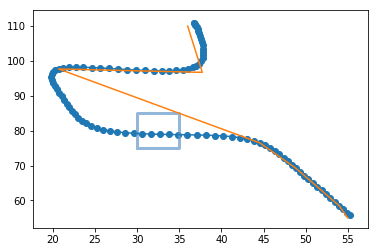

In [93]:
print("start")

plt.plot(ob_x, ob_y, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

plt.plot(y_track_nc[:, 0], y_track_nc[:, 1])
plt.scatter(y_track_nc[:, 0], y_track_nc[:, 1])


rx, ry = PRM_planning(floor(x[0]), floor(y[0]), floor(x[-1]), floor(y[-1]), 
                          [obstacle], dmp=dmp_time_para, dmp_vel=dmp_dy_time_para)

rx = np.array(rx)
ry = np.array(ry)

# plt.legend(plot_paths, legend_key, loc='lower right')
plt.plot(rx, ry)
plt.show()